In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Monte Carlo simulation of the wall effect in a gaseous neutron detector

### Objectives: 

Show how the pulse height spectra is modified with variation of geometry and range of the particles

### Assumptions:
    
    1) 2D geometry
    2) Stopping power of the product particles independent of energy
    3) Only one reaction is considered (single Q-value)
    4) Resolution of the detection process only for the full energy peak


In [2]:
def uniform_points_disc(radius):
    """
    Generation of uniform distributed point inside a disc
    
    Parameters:
        radius: float
            Radius of the disc
    Returns:
        x,y : touple of floats
            Point inside the disc
    """
    theta = np.random.uniform() * 2 * np.pi
    r = radius * np.sqrt(np.random.uniform())
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def find_distance_to_wall(center, angle, radius, particle):
    """
    Solves quadratic ecuation for the intersection of a segment and a circle.

    d**2 +/- 2*[xc*cos(theta) + yc*sin(theta)]*d + xc**2 + yx**2 - radius**2 =0

    Parameters:
        center: (xc, yc)
            Point where the reaction take place
        angle: float
            Angel of the track
        radius: float
            Radius of the circle
        particle: string ('h' or 'l')
            Particle whose track cross the circle. Defines the sign in the equation
    
    Returns:
        d: float
            Distance from the center to the point where the track cross the circle      
    """
    sign = 1 if particle=='h' else -1
    b = sign * 2 * (center[0] * np.cos(angle) + center[1] * np.sin(angle))
    c = center[0]**2 + center[1]**2 - radius**2
    return (-b + np.sqrt(b**2 - 4 * c)) / 2

In [3]:
# Number of points
N = 50000
# Seed
np.random.seed(1)

# Radius of the disc
R = 1
# Range of the heavy particle
range_h = 0.1
# Range of the light particle
range_l = 0.7
# Q value of the reaction
Q = 10
# Kinetic energy of the light particle
Q_l = 8
# Kinetic energy of the heavy particle
Q_h = Q - Q_l

In [4]:
central_points = np.empty((N, 2))
end_points_x = np.empty((N, 2))
end_points_y = np.empty((N, 2))
thetas = np.empty(N)
for i in range(N):
    # Points where the reaction take place
    central_points[i, :] = uniform_points_disc(R)
    # Angle of the track
    theta = np.random.uniform() * 2 * np.pi   
    # x coordinate of the final heavy particle position
    end_points_x[i, 0] = central_points[i, 0] + np.cos(theta) * range_h
    # x coordinate of the final light particle position
    end_points_x[i, 1] = central_points[i, 0] - np.cos(theta) * range_l
    # y coordinate of the final heavy particle position
    end_points_y[i, 0] = central_points[i, 1] + np.sin(theta) * range_h
    # y coordinate of the final light particle position
    end_points_y[i, 1] = central_points[i, 1] - np.sin(theta) * range_l
    thetas[i] = theta

# Check if the track lenght is the sum of the ranges
pp2 = np.diff(end_points_x, axis=1)**2 + np.diff(end_points_y, axis=1)**2
pp = np.sqrt(pp2)
assert all(np.abs(pp - range_h - range_l) <= 1e-9)

<IPython.core.display.Javascript object>


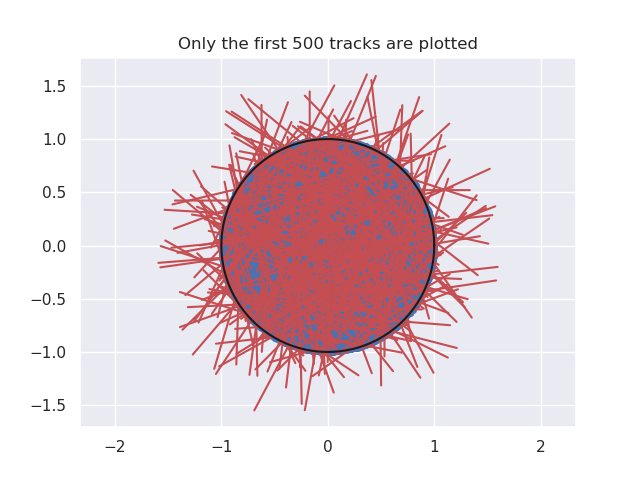

In [5]:
# Points lying in the detectors wall
angle_disc = np.linspace(0, 2 * np.pi, 100)
x_disc = R * np.cos(angle_disc)
y_disc = R * np.sin(angle_disc)

# Plot the tracks only for a few of them
if N < 500:
    fig1, ax1 = plt.subplots(1, 1)
    aa = []
    for i in range(N):
        ax1.plot(end_points_x[i], end_points_y[i], 'r')
    ax1.scatter(central_points[:, 0], central_points[:, 1], s=15)
    ax1.plot(x_disc, y_disc, 'k')
    ax1.axis('equal')
elif N < 1e5:
    # Only plot the first 500 tracks
    fig1, ax1 = plt.subplots(1, 1)
    aa = []
    for i in range(500):
        ax1.plot(end_points_x[i], end_points_y[i], 'r')
    ax1.scatter(central_points[:, 0], central_points[:, 1], s=15)
    ax1.plot(x_disc, y_disc, 'k')
    ax1.axis('equal')
    ax1.set_title("Only the first 500 tracks are plotted")

In [6]:
# Count how many particles hits the detector walls

# Squared norm of the heavy particle end track
end_h_squared = end_points_x[:, 0]**2 + end_points_y[:, 0]**2
# Squared norm of the light particle end track
end_l_squared = end_points_x[:, 1]**2 + end_points_y[:, 1]**2

# Only heavy particles that hit the wall
slice_h = (end_h_squared >= R**2) & (end_l_squared < R**2)
hit_wall_h = sum(slice_h)
# Only light that hit the wall
slice_l = (end_h_squared < R**2) & (end_l_squared >= R**2)
hit_wall_l = sum(slice_l)
# Both heavy and light particles hit the wall
slice_hl = (end_h_squared >= R**2) & (end_l_squared >= R**2)
hit_wall_lh = sum(slice_hl)
# Neither particles hit the wall
none_hit_wall = N - hit_wall_h - hit_wall_l - hit_wall_lh

print(f"Heavy particles hit wall: {hit_wall_h} ({100*hit_wall_h/N}%:.2f)")
print(f"Light particles hit wall: {hit_wall_l} ({100*hit_wall_l/N}%)")
print(f"Both particles hit wall: {hit_wall_lh} ({100*hit_wall_lh/N}%)")
print(f"Neither particles hit wall: {none_hit_wall} ({100*none_hit_wall/N}%)")

Heavy particles hit wall: 2899 (5.798%:.2f)
Light particles hit wall: 21380 (42.76%)
Both particles hit wall: 199 (0.398%)
Neither particles hit wall: 25522 (51.044%)


<IPython.core.display.Javascript object>


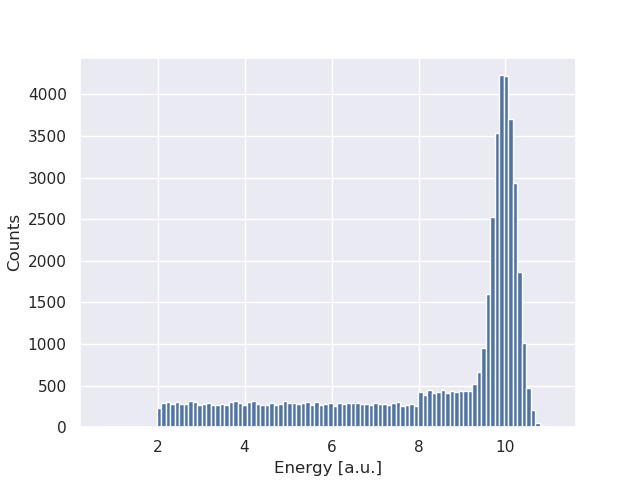

In [7]:
# Energies deposited inside the detector when none of the particles hit the wall
energies = Q * np.ones(N) 
# Basic (and wrong) simulation of the detector resolution (only in flull energy peak)
RES = 0.8
energies += np.random.normal(scale=RES/np.sqrt(Q), size=N)

# Energies desposited when only the heavy particle hits the wall
eng = []
for center, th in zip(central_points[slice_h, :], thetas[slice_h]):
    d_h = find_distance_to_wall(center, th, R, 'h') 
    eng.append(d_h * Q_h / range_h + Q_l)
energies[slice_h] = eng
# Energies desposited when only the light particle hits the wall
eng = []
for center, th in zip(central_points[slice_l, :], thetas[slice_l]):
    d_l = find_distance_to_wall(center, th, R, 'l')
    eng.append(d_l * Q_l / range_l + Q_h)
energies[slice_l] = eng
# Energies desposited when both the heavy and light particle hit the wall
eng = []
for center, th in zip(central_points[slice_hl, :], thetas[slice_hl]):
    d_l = find_distance_to_wall(center, th, R, 'l')
    d_h = find_distance_to_wall(center, th, R, 'h')
    eng.append((d_h * Q_h / range_h) + (d_l * Q_l / range_l))
energies[slice_hl] = eng

fig3, ax3 = plt.subplots(1)
ax3.hist(energies, bins=100);
ax3.set_xlabel("Energy [a.u.]")
ax3.set_ylabel("Counts");
#ax3.set_yscale('log')